# adict
A package for processing multiple `anndata` objects in parallel

# Documentation

To view the documentation, clone this repository, and then navigate to docs/build/index.html and view in a browser.

# Install
Copy and paste the code below into a terminal window to download this package and install it in a conda env. It assumes conda is already installed.

```bash
git clone https://github.com/ggit12/adict
cd adict
conda create -n adict
conda activate adict
pip install -e .
```


# About
`adict` is a package that lets you process multiple `anndata` objects in parallel with a simplified interface (so that you can avoid writing a bunch of for loops). This is accomplished by a dictionary-based wrapping of `scanpy`.

The main function in this package is `adata_dict_fapply()` (and its cousin `adata_dict_fapply_return()`, which does the same thing but also returns the result as a dictionary). 

`adata_dict_fapply()` works just like `lapply()` in R. It takes `adata_dict_fapply(adata_dict, func, **kwargs)`. 

- `adata_dict` is a dictionary.
- `func` is a function to apply over each element of the dictionary.
- `**kwargs` are arguments that `func` takes.

You can have `func` take the argument `key` (i.e., `func(adata, key=None)`) if you want the dictionary key to be available within `func`.

Many functions in adict are built around `adata_dict_fapply()`, and the package provides prebuilt wrappers for several common Scanpy functions, as well as functions to build and concatenate `adata` dictionaries.


Read the tutorial below for basic demonstrations.

# Tutorial
This is the tutorial notebook for `adict`. Follow the tutorial below to get started.


In [1]:
#import the package
import adict as adict

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load an anndata

#for this tutorial, we'll use Tabula Sapiens from cellxgene census
#but you could use any anndata you want
import cellxgene_census

#this command gets liver and kidney from tabula sapiens 
census = cellxgene_census.open_soma(census_version="2023-12-15")
adata = cellxgene_census.get_anndata(
    census,
    organism = "homo_sapiens",
    measurement_name = "RNA",
    obs_value_filter = "(dataset_id == '53d208b0-2cfd-4366-9866-c3c6114081bc') & ((tissue_general == 'liver') | (tissue_general == 'kidney') | (tissue_general == 'spleen'))",
    obs_embeddings = ["uce"]
)



In [4]:
adata

AnnData object with n_obs × n_vars = 48652 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'uce'

In [5]:
#adict has a helpful frequency summary function to do frequencies and joint frequencies
adict.display_html_summary(adict.summarize_metadata(adata, columns = ['tissue','cell_type','cell_type*tissue']))

,count
spleen,34004
kidney,9641
liver,5007
,count
kidney epithelial cell,8331
memory B cell,6460
neutrophil,4622
classical monocyte,4443
"CD8-positive, alpha-beta memory T cell",4301
plasma cell,3205


The first step is to build the dictionary of anndata.  
For this tutorial, we'll build a dictionary of tissue-specific objects, but you could do variables or combinations of variables.

In [6]:
#This command will give an adata_dict where each value is an anndata containing cells from a single tissue
adata_dict = adict.build_adata_dict(adata=adata,strata_keys=['tissue'], desired_strata=['liver','kidney'])

In [7]:
adata_dict

{'liver': View of AnnData object with n_obs × n_vars = 5007 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
     var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     obsm: 'uce',
 'kidney': View of AnnData object with n_obs × n_vars = 9641 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'don

Building adata_dicts is flexible. We could also get only macrophages and endothelial cells from the desired tissues like this:

In [8]:
strata_keys = ['tissue', 'cell_type'] #keys in .obs of each anndata
desired_strata = {'tissue': ['liver', 'kidney'],
                  'cell_type': ['macrophage', 'endothelial cell']
                  }
adata_dict_only_mac_and_endo = adict.build_adata_dict(adata=adata, strata_keys=strata_keys, desired_strata=desired_strata)

In [9]:
adata_dict_only_mac_and_endo

{'liver_macrophage': View of AnnData object with n_obs × n_vars = 1381 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'tissue_cell_type'
     var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     obsm: 'uce',
 'liver_endothelial cell': View of AnnData object with n_obs × n_vars = 267 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id

And we can summarize their metadata using adata_dict wrappers for the previously mentioned summary functions  
Note that each anndata in this dictionary only has 1 tissue and 1 cell type, as it should

In [10]:

adict.display_html_summary_adata_dict(adict.summarize_metadata_adata_dict(adata_dict_only_mac_and_endo, columns = ["tissue", "cell_type", "donor_id"]))

Summary for liver_macrophage:


,count
liver,1381
,count
macrophage,1381
,count
TSP6,1379
TSP14,2


Summary for liver_endothelial cell:


,count
liver,267
,count
endothelial cell,267
,count
TSP14,267


Summary for kidney_macrophage:


,count
kidney,321
,count
macrophage,321
,count
TSP2,321


Summary for kidney_endothelial cell:


,count
kidney,95
,count
endothelial cell,95
,count
TSP2,95


For the rest of this tutorial, we'll use adata_dict that has multiple celltypes per tissue

In [11]:

adict.display_html_summary_adata_dict(adict.summarize_metadata_adata_dict(adata_dict, columns = ["cell_type"]))

Summary for liver:


,count
hepatocyte,1558
macrophage,1381
monocyte,612
endothelial cell of hepatic sinusoid,421
endothelial cell,267
mature NK T cell,245
T cell,146
erythrocyte,108
neutrophil,83
fibroblast,76


Summary for kidney:


,count
kidney epithelial cell,8331
B cell,341
macrophage,321
"CD8-positive, alpha-beta T cell",241
CD4-positive helper T cell,181
mature NK T cell,131
endothelial cell,95


Now, let's do some standard scanpy preprocessing
Each anndata in the dictionary will be processed independently

Note: since many of these functions are scanpy wrappers, they take and pass any function arguments to their underlying scanpy functions.
resample_adata_dict uses sc.pp.subsample under the hood and so takes n_obs or fraction (among others)

In [12]:
#Subset each celltype to 1000 cells and drop celltypes with fewer than 50 cells
adata_dict = adict.resample_adata_dict(adata_dict, strata_keys=['cell_type'], min_num_cells=50, n_obs=1000)

In [13]:
#Confirm that the subsampling and dropping has been performed
adict.display_html_summary_adata_dict(adict.summarize_metadata_adata_dict(adata_dict, columns = ["cell_type"]))

Summary for liver:


,count
hepatocyte,1000
macrophage,1000
monocyte,612
endothelial cell of hepatic sinusoid,421
endothelial cell,267
mature NK T cell,245
T cell,146
erythrocyte,108
neutrophil,83
fibroblast,76


Summary for kidney:


,count
kidney epithelial cell,1000
B cell,341
macrophage,321
"CD8-positive, alpha-beta T cell",241
CD4-positive helper T cell,181
mature NK T cell,131
endothelial cell,95


In [14]:
adata_dict

{'liver': AnnData object with n_obs × n_vars = 3958 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
     obsm: 'uce',
 'kidney': AnnData object with n_obs × n_vars = 2310 × 60664
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ont

Plotting UMAP for key: liver


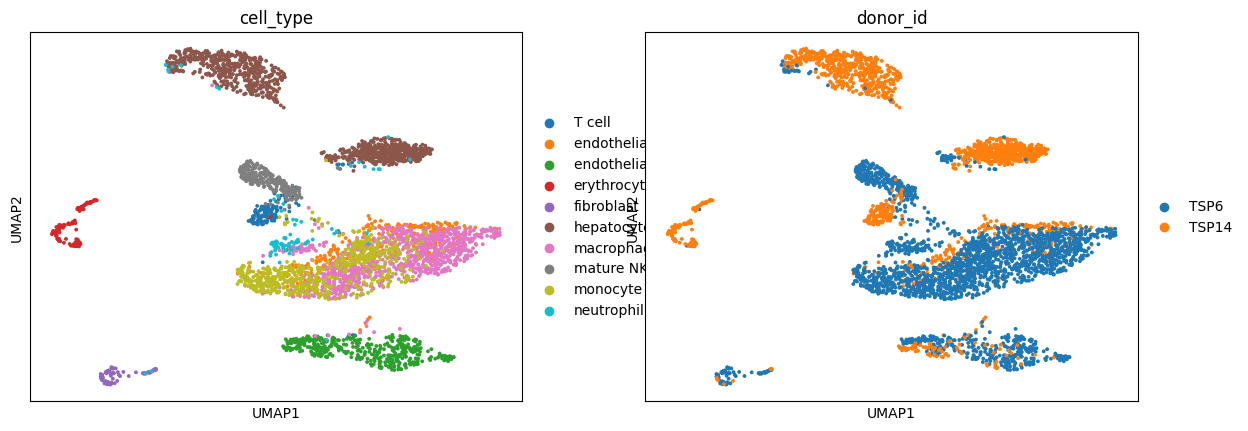

Plotting UMAP for key: kidney


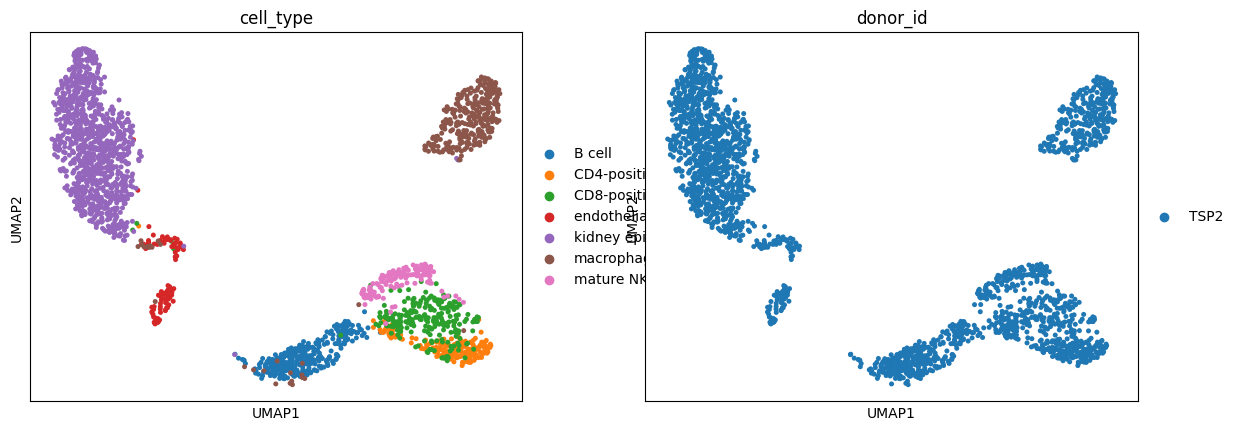

In [15]:
# Normalize each AnnData in the dictionary
adict.normalize_adata_dict(adata_dict)

# Log transform each AnnData in the dictionary
adict.log_transform_adata_dict(adata_dict)

# Optionally, you might subset the data to only high-variance genes
adict.set_high_variance_genes(adata_dict, n_top_genes=2000, subset=False)

# Scale each AnnData in the dictionary
adict.scale_adata_dict(adata_dict)

# Perform PCA on each AnnData in the dictionary
adict.pca_adata_dict(adata_dict, n_comps=50, mask_var='highly_variable')

# Calculate and plot UMAP based on pca
adict.calculate_umap_adata_dict(adata_dict, use_rep='X_pca')
adict.plot_umap_adata_dict(adata_dict, color_by = ['cell_type', 'donor_id'])


In [16]:
# Write each adata in adata_dict separately
adict.write_h5ad_adata_dict(adata_dict, "~/adatas", file_prefix="adata_")

In [17]:
#Concatenate the adata_dict back to a single anndata
adata = adict.concatenate_adata_dict(adata_dict)

In [18]:
adict.display_html_summary(adict.summarize_metadata(adata, columns = ['tissue','cell_type','cell_type*tissue']))

,count
liver,3958
kidney,2310
,count
macrophage,1321
hepatocyte,1000
kidney epithelial cell,1000
monocyte,612
endothelial cell of hepatic sinusoid,421
mature NK T cell,376
endothelial cell,362
